# Proiect RNA: Compararea performantelor modelelor si selectarea modelului optim

Notebook executabil care contine:
- agregarea metricilor pe setul de test pentru toate modelele (metrics_*.csv -> metrics_all_models.csv)
- compararea rezultatelor (RMSE, MAE, R2)
- identificarea modelului optim (RMSE test minim)
- graficele comparative regenerate


In [25]:
import os
import subprocess
import sys

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

print("Workdir:", os.getcwd())
print("Python:", sys.version.split()[0])

def show_png(path, title=None, width=1200):
    if not os.path.exists(path):
        print("MISSING:", path)
        return
    img = Image.open(path)
    plt.figure(figsize=(width/100, width/170))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


Workdir: c:\Proiect_Retele_cod
Python: 3.12.10


## 1. Regenerare comparatii (obligatoriu pentru notebook executabil)

Rulam `compare_all_models.py` pentru a:
- reface `metrics_all_models.csv` din fisierele `metrics_*.csv`
- regenera graficele comparative (RMSE/MAE/R2 pe test)

Nota: acest pas NU reantreneaza modelele, doar agregeaza si ploteaza.


In [26]:
subprocess.run([sys.executable, "compare_all_models.py"], check=True)
print("OK: metrics_all_models.csv si graficele comparative au fost regenerate.")


OK: metrics_all_models.csv si graficele comparative au fost regenerate.


## 2. Tabel agregat cu rezultatele pe setul de test

Incarcam `metrics_all_models.csv` si afisam toate modelele evaluate.


In [27]:
metrics_path = "metrics_all_models.csv"
if not os.path.exists(metrics_path):
    raise FileNotFoundError("Nu gasesc metrics_all_models.csv. Verifica rularea celulei de regenerare.")

dfm = pd.read_csv(metrics_path)
print("metrics_all_models.csv shape:", dfm.shape)
display(dfm)


metrics_all_models.csv shape: (6, 12)


,model,rmse_train,mae_train,r2_train,rmse_val,mae_val,r2_val,rmse_test,mae_test,r2_test,runtime_sec,source_file
0,MLPRegressor,NaN,NaN,NaN,12338.200402,8490.587551,0.581553,11823.744443,8269.142064,0.586494,1.579,metrics_mlp.csv
1,RBF_scratch,NaN,NaN,NaN,17066.432638,8804.596153,0.199387,17483.646185,11188.636668,0.095861,NaN,metrics_rbf_scratch.csv
2,BayesianRidge_prob,NaN,NaN,NaN,3317.556466,2401.743212,0.969747,3508.463886,2562.895636,0.963591,0.059,metrics_bayesian_ridge.csv
3,FuzzySugeno_concept,NaN,NaN,NaN,2392.405360,1735.784304,0.984267,2938.790202,2278.047655,0.974455,0.036,metrics_fuzzy_sugeno.csv
4,RNN_Elman_scratch,NaN,NaN,NaN,19108.666079,12685.296120,-0.007432,18417.732892,12277.944595,-0.003330,3.655,metrics_rnn_elman_scratch.csv
5,GA_opt_MLP,NaN,NaN,NaN,1996.467297,NaN,NaN,2493.391256,1899.724718,0.981611,84.775,ga_best_mlp.csv


## 3. Clasament modele + selectarea modelului optim (RMSE test minim)

Criteriu: RMSE minim pe setul de test.
Afisam clasamentul complet si apoi modelul optim.


In [28]:
# Verificare coloane necesare
required_cols = ["model", "rmse_test", "mae_test", "r2_test", "source_file"]
missing = [c for c in required_cols if c not in dfm.columns]

if missing:
    print("Lipsesc coloane:", missing)
    print("Coloane existente:", list(dfm.columns))
else:
    # Copie defensiva + conversii numerice
    tmp = dfm.copy()
    tmp["rmse_test"] = pd.to_numeric(tmp["rmse_test"], errors="coerce")
    tmp["mae_test"] = pd.to_numeric(tmp["mae_test"], errors="coerce")
    tmp["r2_test"] = pd.to_numeric(tmp["r2_test"], errors="coerce")

    # Sortare dupa RMSE pe setul de test
    tmp_sorted = tmp.sort_values("rmse_test", ascending=True)

    # Afisare clasament complet
    print("=== RANK (best RMSE_test first) ===")
    display(tmp_sorted[["model", "rmse_test", "mae_test", "r2_test", "source_file"]])

    # Selectare si afisare BEST MODEL – FORMAT IDENTIC CU RAPORTUL
    cols_best = ["model", "rmse_test", "mae_test", "r2_test", "source_file"]
    best = tmp_sorted.iloc[0].reindex(cols_best)

    print("Best model (RMSE test minim):")
    print(best.to_string())


=== RANK (best RMSE_test first) ===


,model,rmse_test,mae_test,r2_test,source_file
5,GA_opt_MLP,2493.391256,1899.724718,0.981611,ga_best_mlp.csv
3,FuzzySugeno_concept,2938.790202,2278.047655,0.974455,metrics_fuzzy_sugeno.csv
2,BayesianRidge_prob,3508.463886,2562.895636,0.963591,metrics_bayesian_ridge.csv
0,MLPRegressor,11823.744443,8269.142064,0.586494,metrics_mlp.csv
1,RBF_scratch,17483.646185,11188.636668,0.095861,metrics_rbf_scratch.csv
4,RNN_Elman_scratch,18417.732892,12277.944595,-0.003330,metrics_rnn_elman_scratch.csv


Best model (RMSE test minim):
model               GA_opt_MLP
rmse_test          2493.391256
mae_test           1899.724718
r2_test               0.981611
source_file    ga_best_mlp.csv


## 4. Grafice comparative regenerate (TEST)

Afisam graficele comparative generate de `compare_all_models.py`.


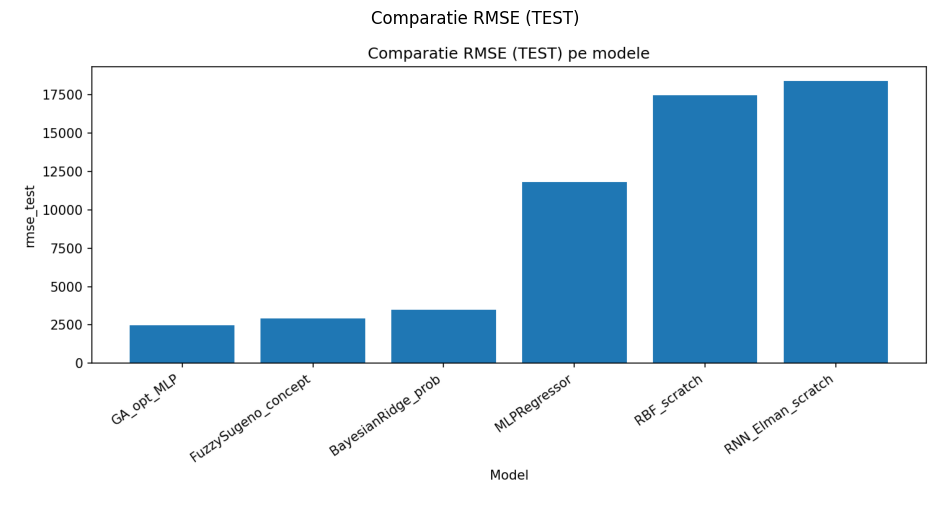

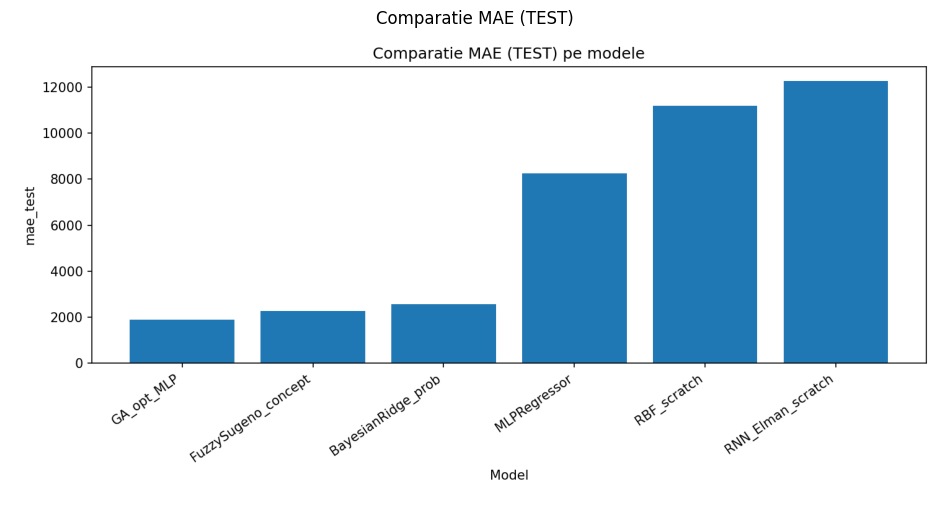

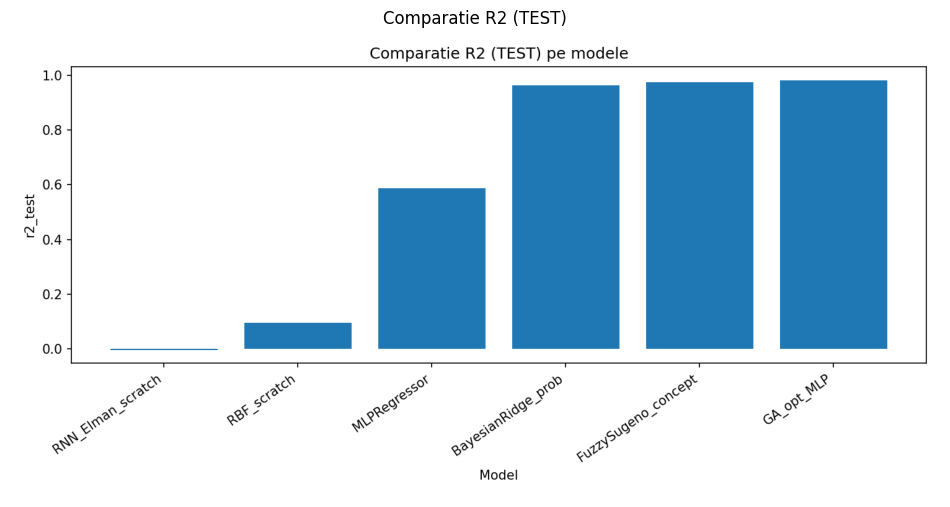

In [29]:
comparative_pngs = [
    ("plot_compare_rmse_test.png", "Comparatie RMSE (TEST)"),
    ("plot_compare_mae_test.png", "Comparatie MAE (TEST)"),
    ("plot_compare_r2_test.png", "Comparatie R2 (TEST)"),
]

for p, t in comparative_pngs:
    show_png(p, t)


## 5. Concluzie sintetica

- Modelul optim este cel cu RMSE minim pe setul de test.
- Clasamentul complet permite compararea obiectiva intre arhitecturi (MLP, RBF, RNN Elman/Jordan, SOM, Hopfield, Fuzzy, Bayesian Ridge etc.).
- Graficele comparative confirma vizual diferentele de performanta intre modele.


## Anexa – Toate graficele generate de pipeline

In aceasta sectiune sunt afisate toate fisierele PNG generate in cadrul proiectului.
Graficele includ:
- curbe de invatare
- comparatii intre modele
- predictii vs valori reale
- reziduuri
- reprezentari SOM, Hopfield etc.

Aceasta anexa demonstreaza completitudinea pipeline-ului si faptul ca rezultatele grafice au fost generate efectiv.


Numar total de grafice PNG: 21


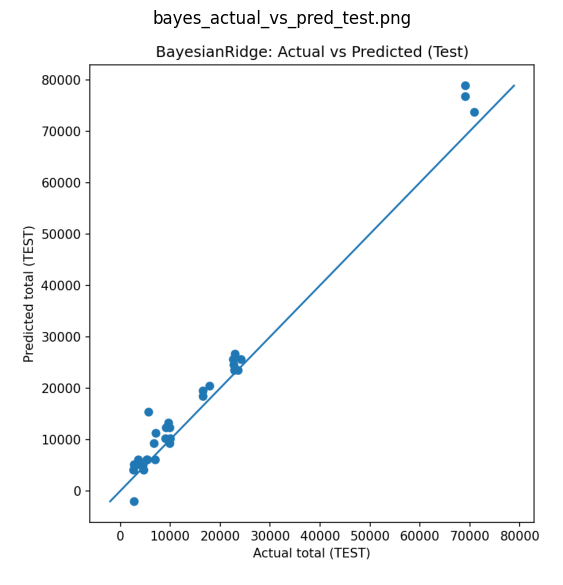

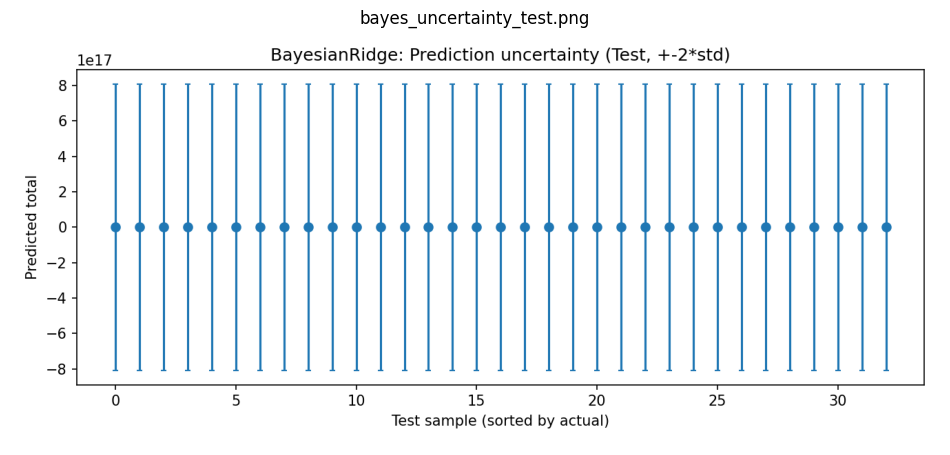

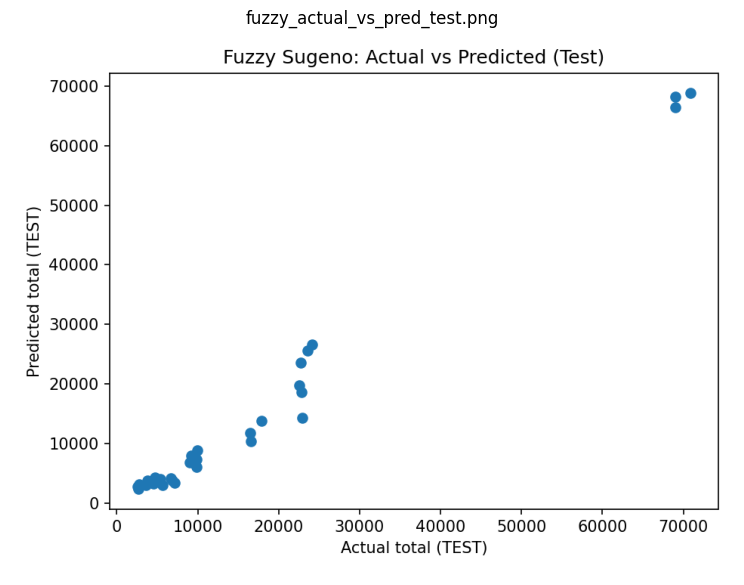

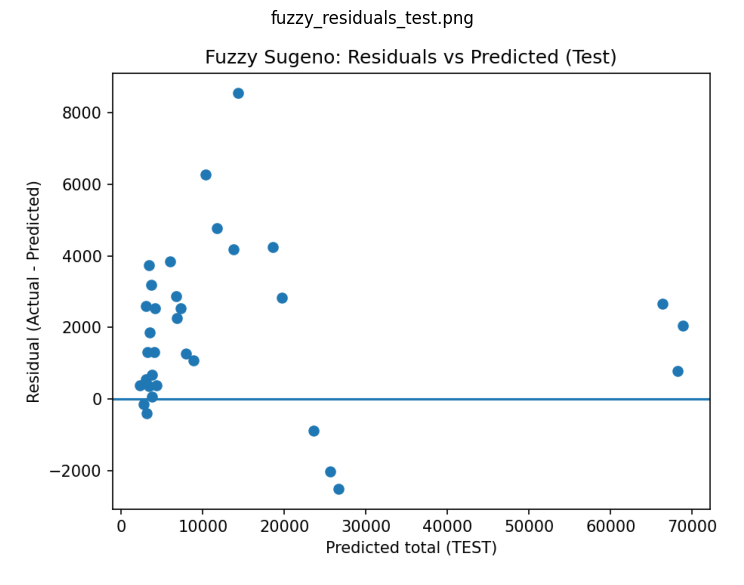

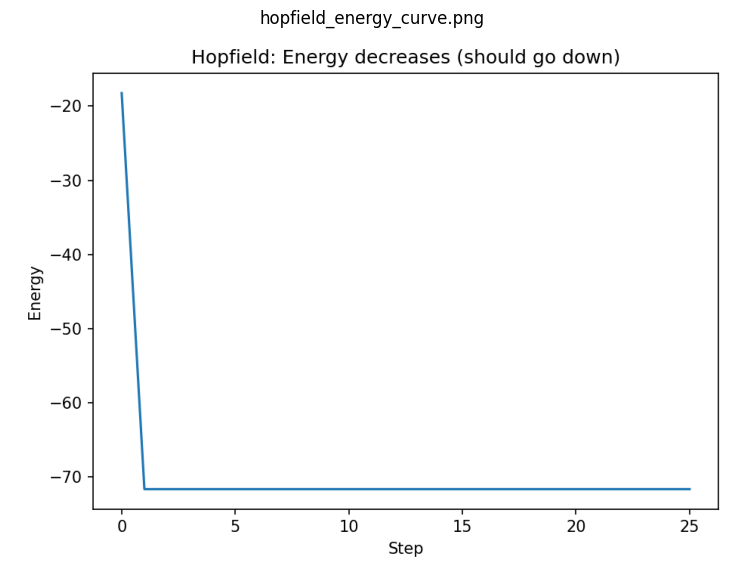

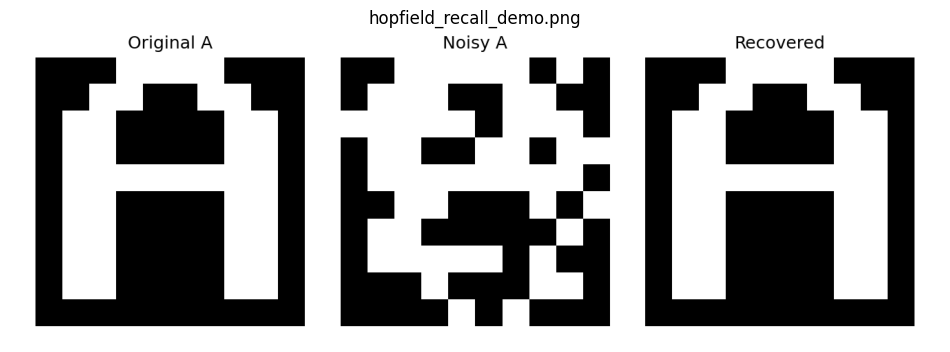

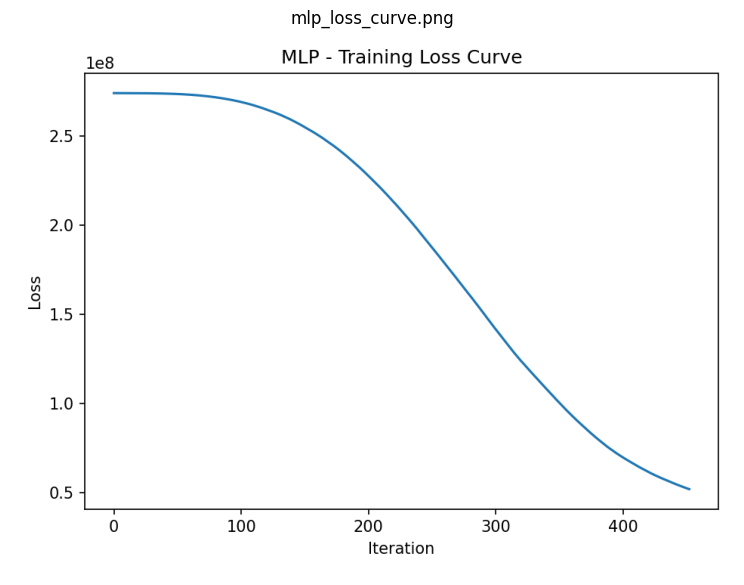

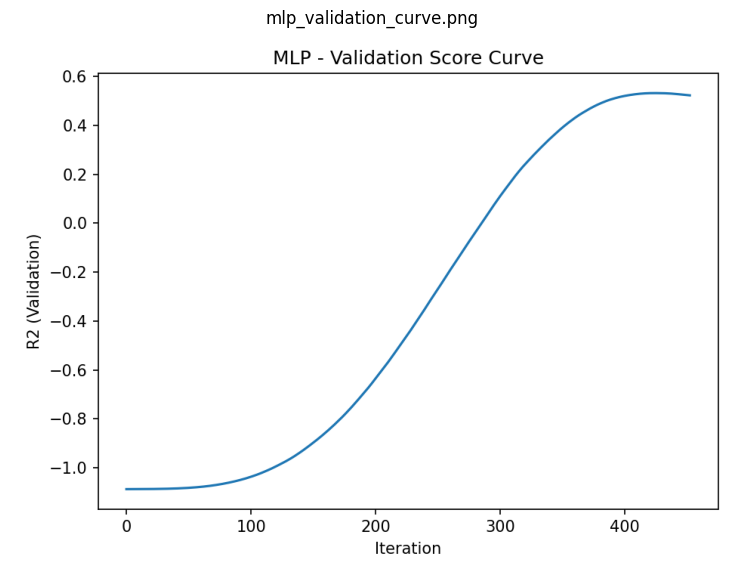

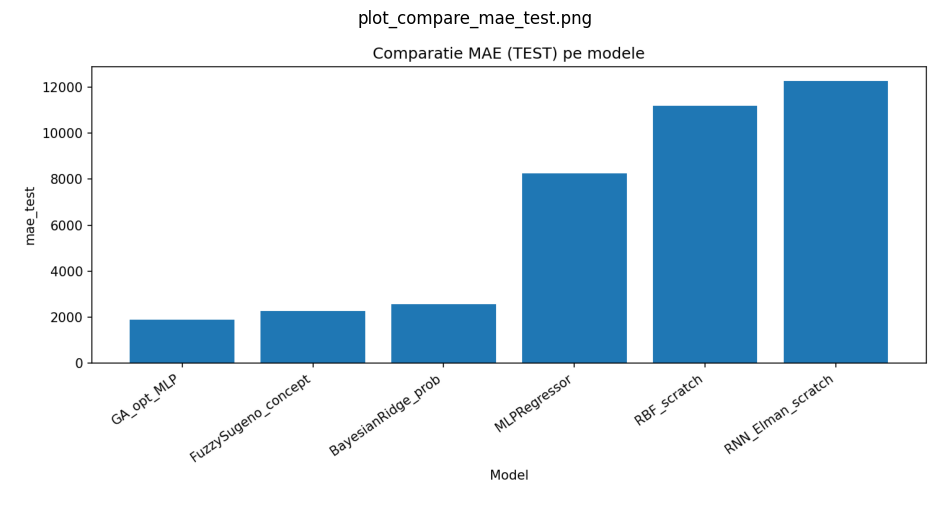

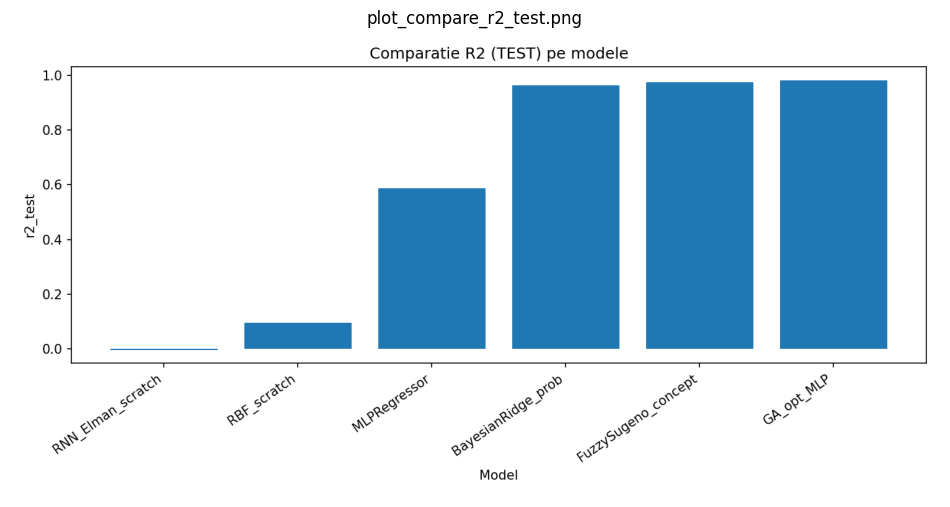

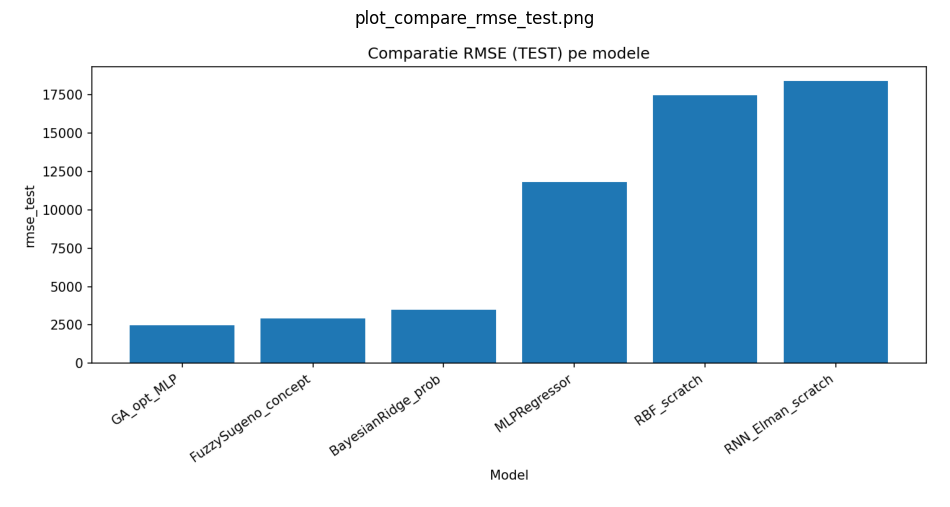

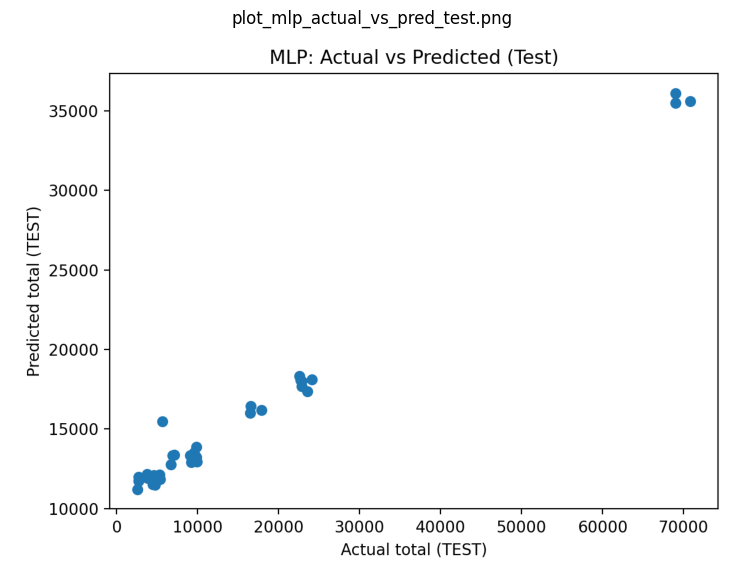

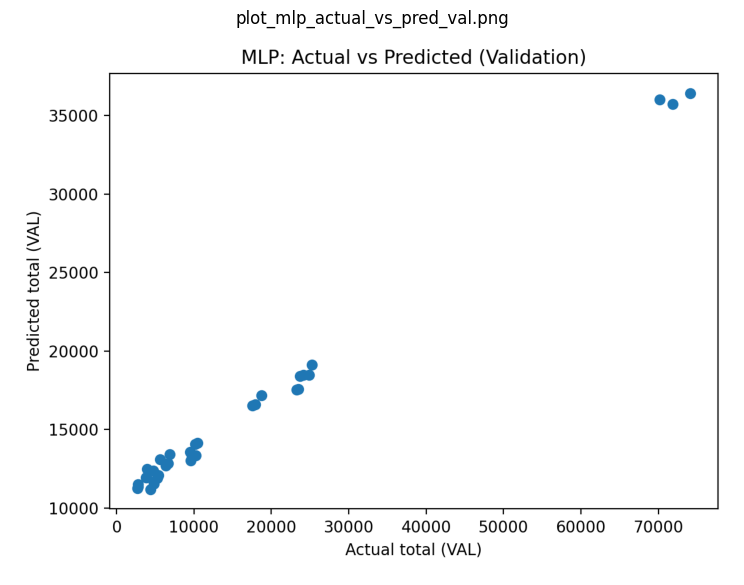

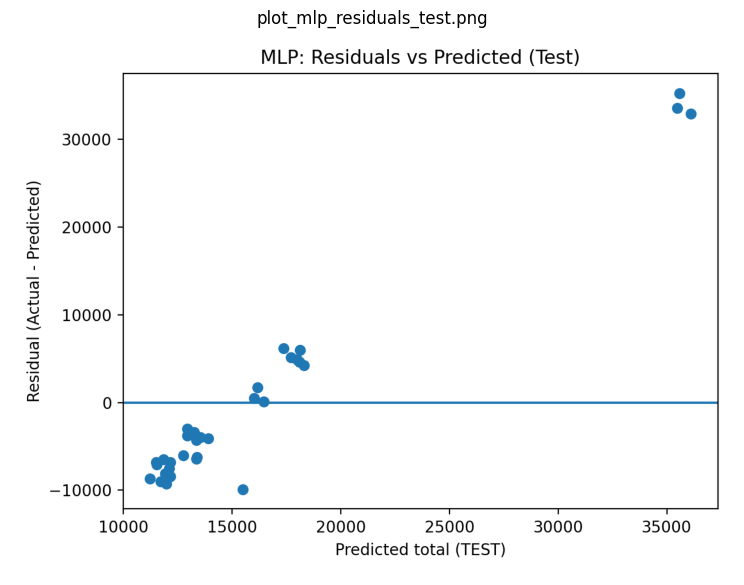

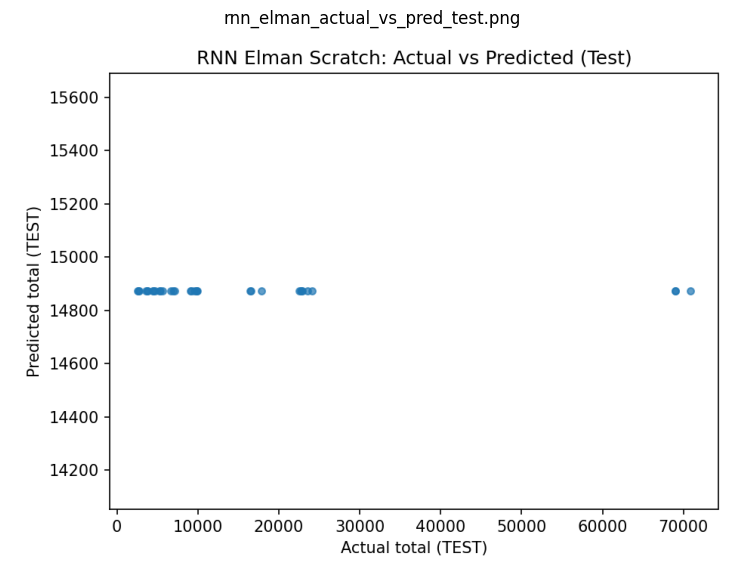

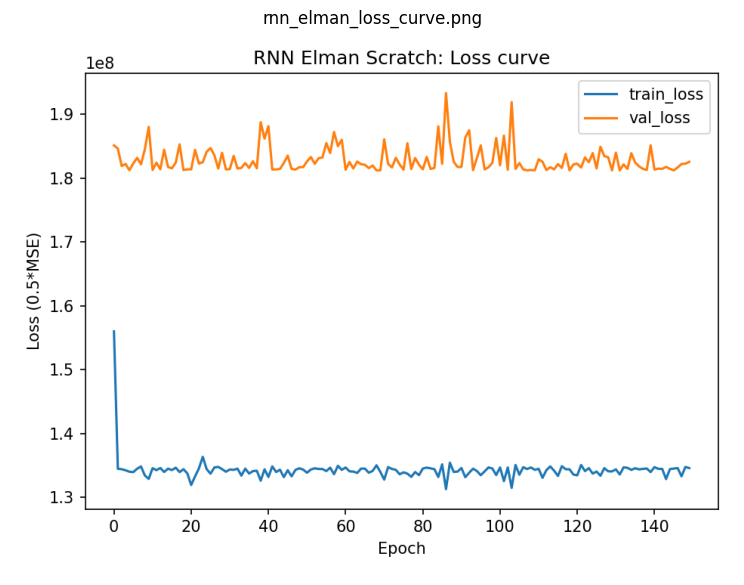

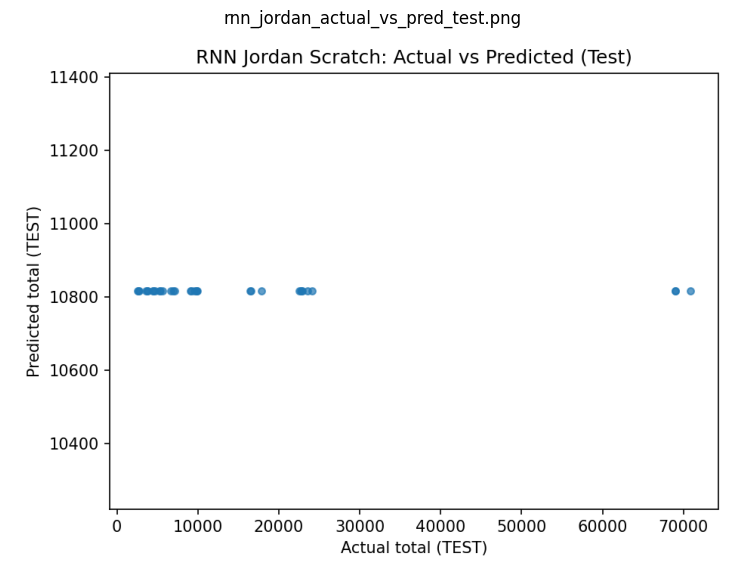

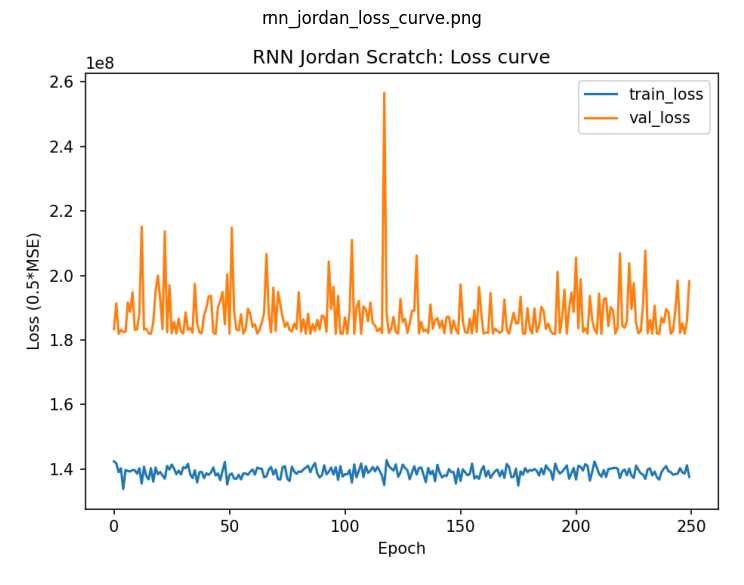

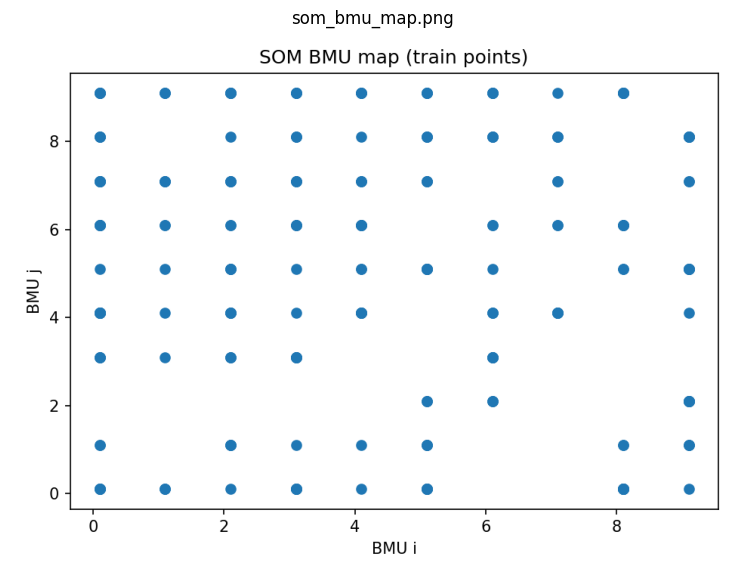

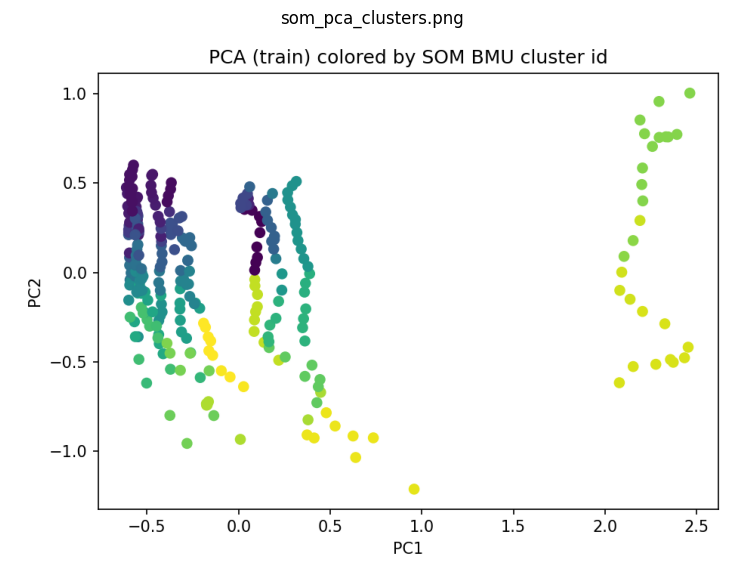

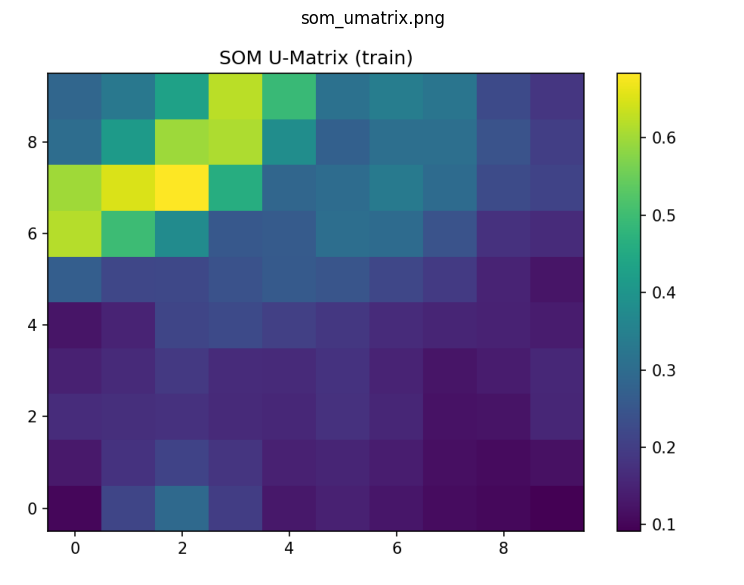

In [30]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Functie de afisare PNG
def show_png(path, width=1200):
    img = Image.open(path)
    plt.figure(figsize=(width/100, width/170))
    plt.imshow(img)
    plt.axis("off")
    plt.title(path)
    plt.show()

# Colectare automata a tuturor PNG-urilor din folder
png_files = sorted([f for f in os.listdir(".") if f.lower().endswith(".png")])

print(f"Numar total de grafice PNG: {len(png_files)}")

# Afisare fiecare PNG
for png in png_files:
    show_png(png)
